### Load data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from collections import defaultdict
from scipy.stats import pearsonr
from sklearn.metrics import confusion_matrix

from src.utils.io import read_json
from src.utils.plotting import *
from conf_prediction.utils import *
from conf_prediction.abs_error import conformal_calibrate
from conf_prediction.quantile import *
from conf_prediction.phiseg_calibrate import *


datasets = ['hc18', 'jsrt', 'ph2', 'psfhs', 'scd', 'irca', 'wbc_cv', 'wbc_jtsc', 'isic 2018', 'nucls']

def process_dataset(data, metric='Dice'):
    real_scores = []
    rca_scores = []
    for x in data:
        real = x['Real score'][metric]
        rca_list = x['RCA score'][metric]

        if not np.all(np.isfinite(real)):
            continue

        for rca_array in rca_list:
            rca_array = np.array(rca_array)
            if rca_array.ndim == 1:
                rca_array = rca_array.reshape(-1, 1)

        real_scores.append(real)
        rca_scores.append(np.array([v for v in rca_list]))

    return {'Real score': real_scores, 'RCA score': rca_scores}


data = {'sam': {}, 'useg': {}, 'atlas-ra': {}, 'atlas': {}, 'useg-no-ra': {}}
metric = 'Dice'

paths = {
    'sam': 'results/phiseg/sam2/',
    'useg': 'results/phiseg/universeg',
    'atlas-ra': 'results/phiseg/atlas-ra/',
    'atlas': 'results/phiseg/atlas/',
}

for dataset in datasets:
    for model, base_path in paths.items():
        test_data = read_json(os.path.join(base_path, f"{dataset}_test.json"))
        cal_data = read_json(os.path.join(base_path, f"{dataset}_cal.json"))
        data[model][dataset] = {
            'test': process_dataset(test_data, metric),
            'cal': process_dataset(cal_data, metric)
        }

### In-Context RCA

In [8]:
def reduce(dataset, predictor='mean', n=8):
    res = {}
    res['Real'] = dataset['Real score']
    
    rca = np.array(dataset['RCA score'])[:, :n]
    rca = np.ma.masked_invalid(rca)
    
    if predictor == 'mean':
        rca = np.mean(rca, axis=1)
    elif predictor == 'max':
        rca= np.max(rca, axis=1)
    elif predictor == 'min':
        rca = np.min(rca, axis=1)

    res['Predicted'] = rca.tolist()
    return res

predictors = {
    'useg': 'max',
    'sam': 'mean',
    'atlas-ra': 'max',
    'atlas': 'max',
}

data_red = {model: {} for model in predictors}

for dataset in datasets:
    for model, predictor in predictors.items():
        data_red[model][dataset] = {
            'test': reduce(data[model][dataset]['test'], predictor=predictor),
            'cal': reduce(data[model][dataset]['cal'], predictor=predictor)
        }

datasets_list = list(data_red['useg'].keys())
dataset_class_pairs = []

for dataset_name in datasets_list:
    real = np.array(data_red['useg'][dataset_name]['test']['Real'])
    n_classes = real.shape[1] if real.ndim == 2 else 1
    for class_idx in range(n_classes):
        dataset_class_pairs.append((dataset_name, class_idx))

n_plots = len(dataset_class_pairs)

In [20]:
ns = [2, 5, 10, 25]
models = ['useg', 'useg-no-ra']

# Same predictor for both, or you can make it a dict if needed
predictor = 'max'

data_red_n = {n: {model: {} for model in models} for n in ns}

for n in ns:
    for model in models:
        for dataset in datasets:
            if model not in data or dataset not in data[model]:
                continue  # Skip if missing
            try:
                test_reduced = reduce(data[model][dataset]['test'], predictor=predictor, n=n)
                data_red_n[n][model][dataset] = {
                    'test': test_reduced,
                }
            except Exception as e:
                print(f"Skipping {model} - {dataset} - n={n}: {e}")


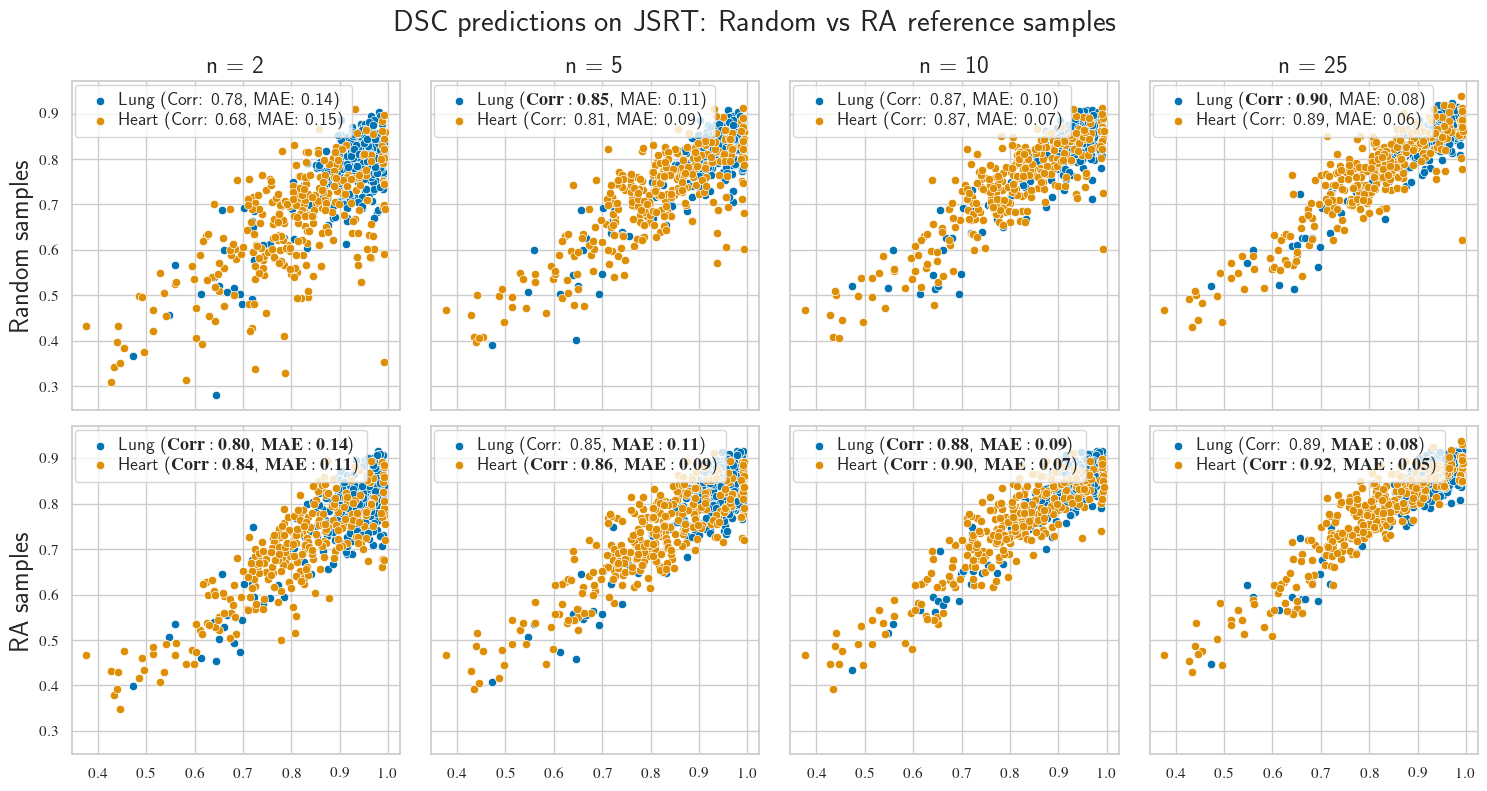

In [ ]:
ns     = [2, 5, 10, 25]
models = ['useg-no-ra', 'useg']
row_labels = ['Random samples', 'RA samples']

# pull class names from your jsrt config
class_names = ['Lung', 'Heart']

fig, axes = plt.subplots(2, len(ns),
                         figsize=(4*len(ns), 8),
                         sharex=True, sharey=True)
sns.set_theme(style="whitegrid")

for j, n in enumerate(ns):
    # 1) compute metrics per model per class
    stats = {}
    for model in models:
        res = data_red_n[n][model]['jsrt']['test']
        real = np.array(res['Real'])       # shape (N, n_classes)
        pred = np.array(res['Predicted'])

        # mask invalid
        mask = np.isfinite(real) & np.isfinite(pred)
        real = real[mask].reshape(-1, real.shape[1])
        pred = pred[mask].reshape(-1, pred.shape[1])

        # compute corr & mae per class index
        n_classes = real.shape[1]
        corrs = []
        maes  = []
        for c in range(n_classes):
            r = real[:,c]
            p = pred[:,c]
            corrs.append(np.corrcoef(r, p)[0,1])
            maes .append(np.mean(np.abs(r - p)))
        stats[model] = dict(real=real,
                            pred=pred,
                            corr_list=corrs,
                            mae_list=maes)

    # 2) pick winners **per class**
    #    higher corr wins, lower mae wins
    winner_corr = []
    winner_mae  = []
    for c in range(len(class_names)):
        # compare models for class c
        best_corr = max(models, key=lambda m: stats[m]['corr_list'][c])
        best_mae  = min(models, key=lambda m: stats[m]['mae_list'][c])
        winner_corr.append(best_corr)
        winner_mae .append(best_mae)

    # 3) plot each cell
    for i, model in enumerate(models):
        ax = axes[i, j]
        s = stats[model]

        # build bold lists for this model
        bold_corr_list = [ (model == winner_corr[c]) for c in range(len(class_names)) ]
        bold_mae_list  = [ (model == winner_mae [c]) for c in range(len(class_names)) ]

        plot_scores_multi(
            ax,
            real_scores     = s['real'],
            pred_scores     = s['pred'],
            class_names     = class_names,
            bold_corr_list  = bold_corr_list,
            bold_mae_list   = bold_mae_list
        )

        # row y‑labels only on first col
        if j == 0:
            ax.set_ylabel(row_labels[i], fontsize=19)
        # col titles only on first row
        if i == 0:
            ax.set_title(f"n = {n}", fontsize=18)

        ax.set_box_aspect(1)

# 4) layout + super‑title
fig.suptitle("DSC predictions on JSRT: Random vs RA reference samples", fontsize=22)
plt.tight_layout(rect=[0, 0, 1, 0.995])
plt.subplots_adjust(wspace=-0.1, hspace=0.05)

plt.savefig("figures/UniverSeg_jsrt.svg", dpi=300, bbox_inches="tight")
plt.show()


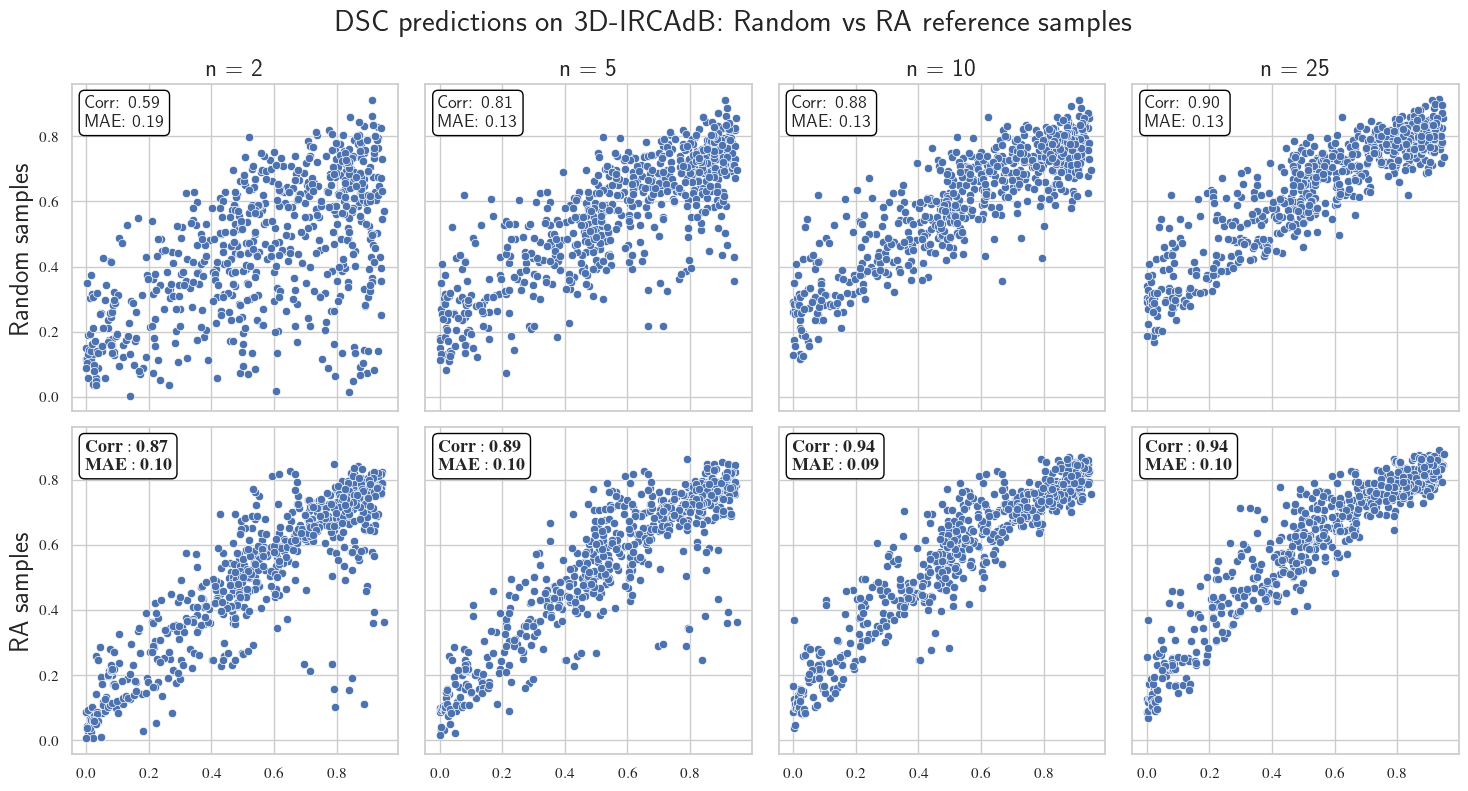

In [47]:
fig, axes = plt.subplots(2, len(ns), figsize=(4*len(ns), 8), sharex=True, sharey=True)
sns.set_theme(style="whitegrid")

for j, n in enumerate(ns):
    # gather metrics for both models
    stats = {}
    for i, model in enumerate(models):
        res = data_red_n[n][model]['irca']['test']
        real = np.array(res['Real'])
        pred = np.array(res['Predicted'])

        # filter invalids
        mask = np.isfinite(real) & np.isfinite(pred)
        real, pred = real[mask], pred[mask]

        corr = np.corrcoef(real, pred)[0,1]
        mae  = np.mean(np.abs(real - pred))
        stats[model] = dict(real=real, pred=pred, corr=corr, mae=mae)

    # decide winners column‑wise
    # e.g. higher corr wins, lower mae wins
    winner_corr = max(models, key=lambda m: stats[m]['corr'])
    winner_mae  = min(models, key=lambda m: stats[m]['mae'])

    # plot each row
    for i, model in enumerate(models):
        ax = axes[i, j]
        s = stats[model]
        bold_corr = (model == winner_corr)
        bold_mae  = (model == winner_mae)

        plot_score(
            ax,
            real_scores = s['real'],
            pred_scores = s['pred'],
            bold_corr  = bold_corr,
            bold_mae   = bold_mae
        )

        # row y‑labels only on first column
        if j == 0:
            ax.set_ylabel(row_labels[i], fontsize=19)
        # column titles only on first row
        if i == 0:
            ax.set_title(f"n = {n}", fontsize=18)

        ax.set_box_aspect(1)

plt.tight_layout(rect=[0, 0, 1, 0.935])
plt.subplots_adjust(wspace=-0.2, hspace=0.05)
fig.suptitle("DSC predictions on 3D-IRCAdB: Random vs RA reference samples", fontsize=22)


plt.savefig("figures/UniverSeg_irca.svg", dpi=300, bbox_inches="tight")
plt.show()

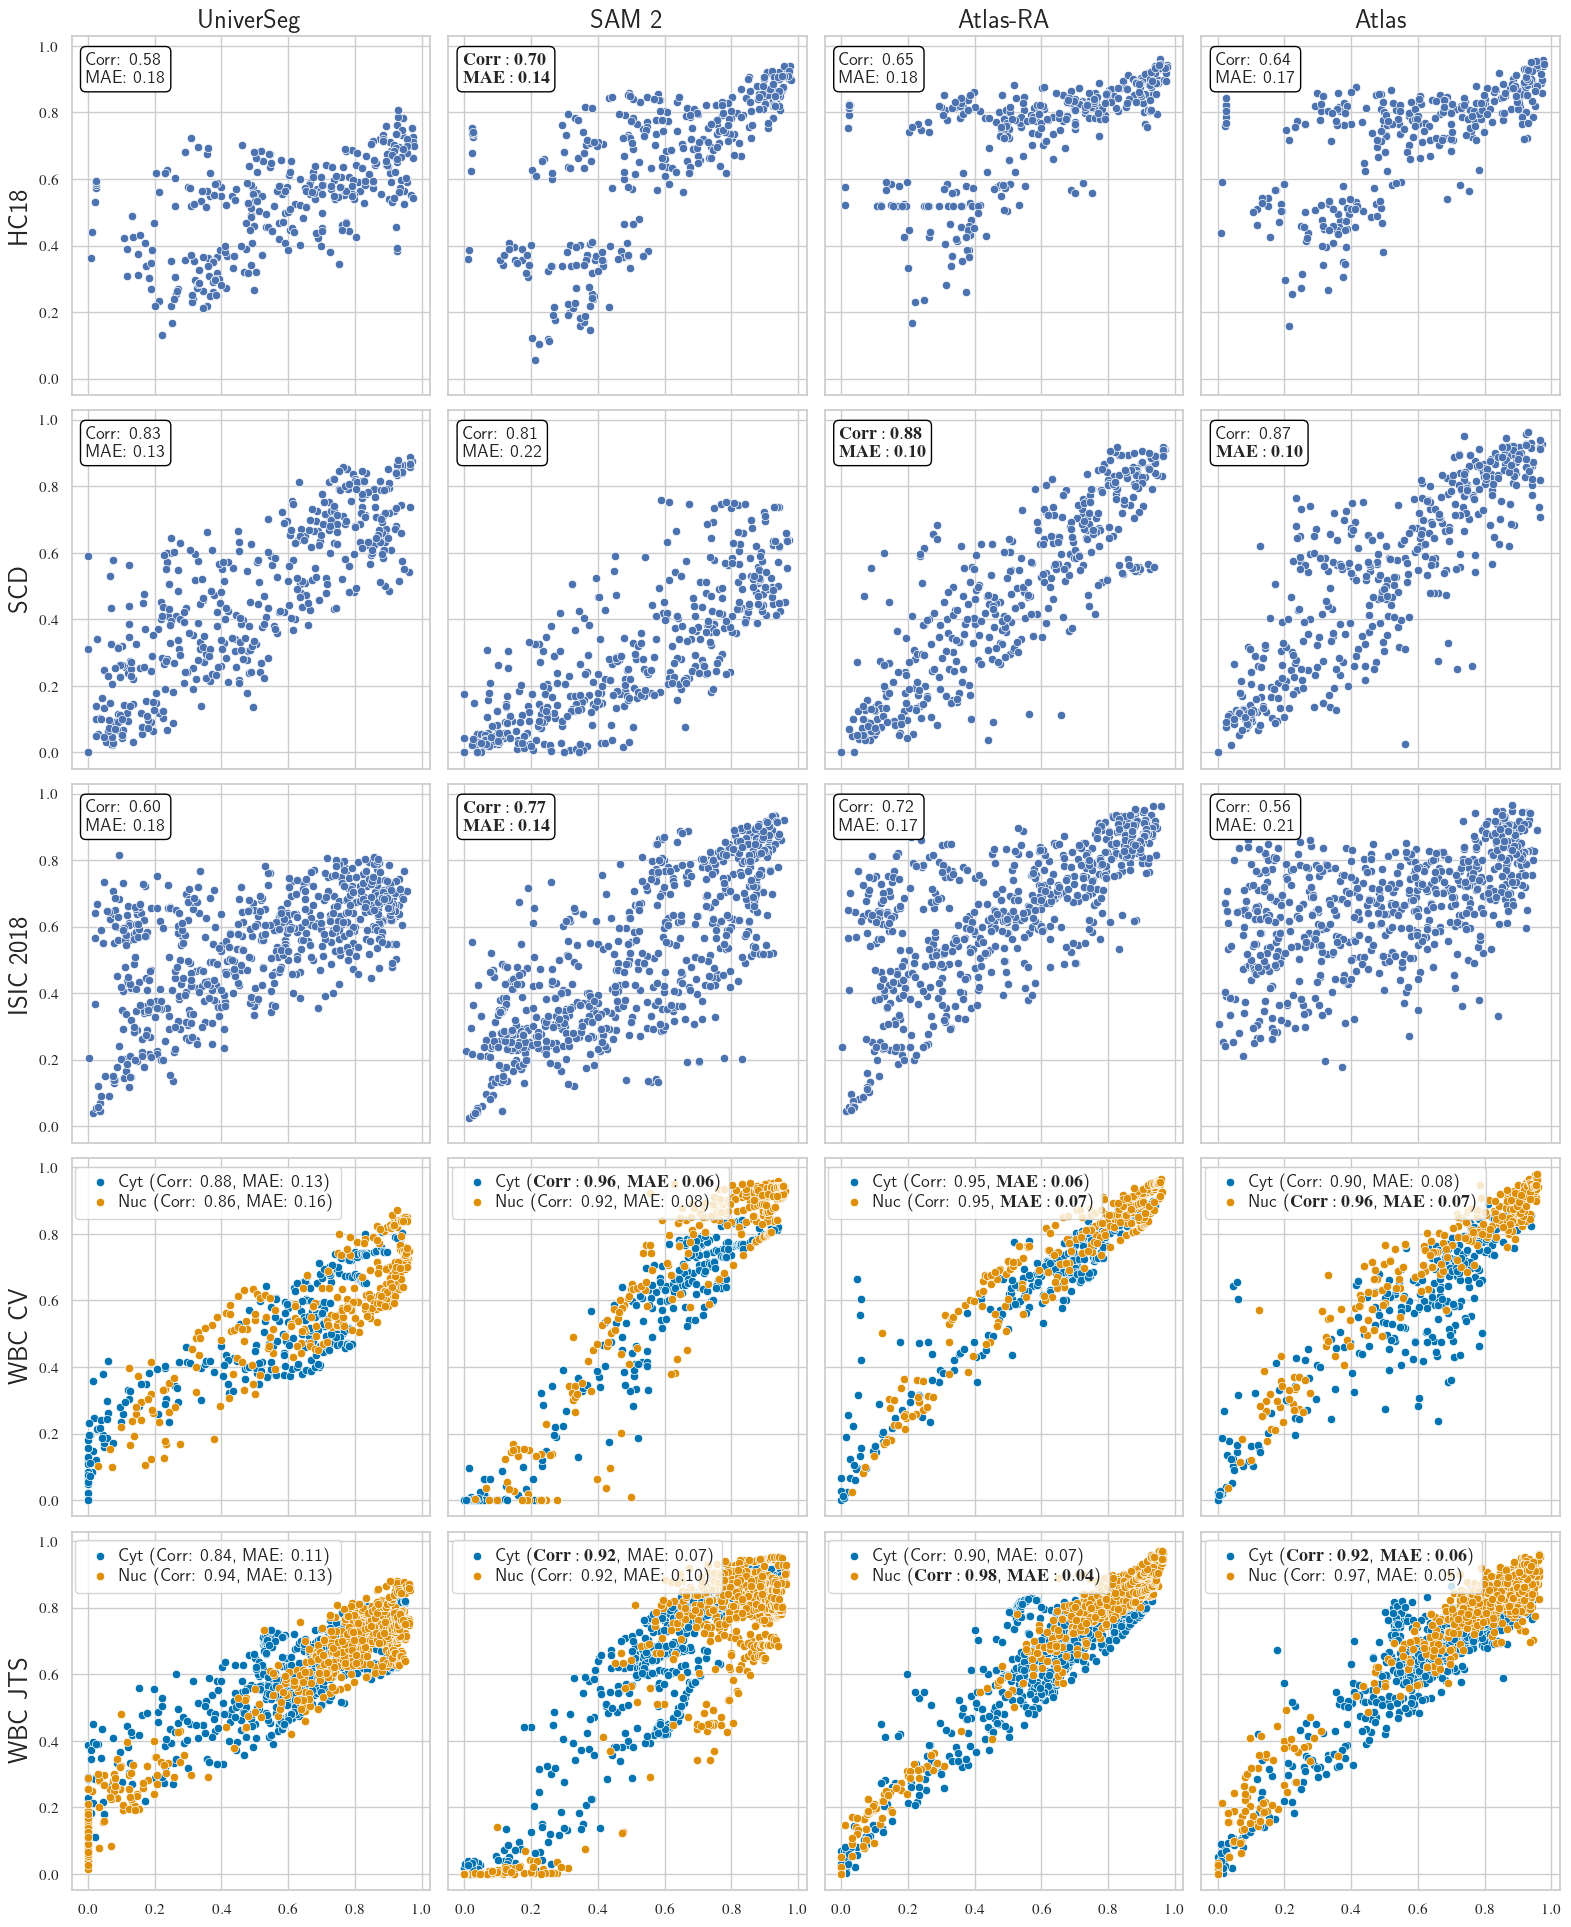

In [10]:
# Dataset configuration
dataset_configs = [
    {'var': 'nucls_dict', 'name': 'NuCLS', 'key': 'hc18'},
    {'var': 'ircadb_dict', 'name': '3D-IRCAdB', 'key': 'irca'},
    {'var': 'ph2_dict', 'name': 'PH2', 'key': 'ph2'},
    {'var': 'jsrt_dict', 'name': 'JSRT', 'key': 'jsrt', 'is_multiclass': True, 'class_names': ['Lung', 'Heart']},
    {'var': 'psfhs_dict', 'name': 'PSFHS', 'key': 'psfhs', 'is_multiclass': True, 'class_names': ['PS', 'FH']},
    {'var': 'scd_dict', 'name': 'SCD', 'key': 'scd'},
    {'var': 'isic_dict', 'name': 'ISIC 2018', 'key': 'isic 2018'},
    {'var': 'wbc_cv_dict', 'name': 'WBC CV', 'key': 'wbc_cv', 'is_multiclass': True, 'class_names': ['Cyt', 'Nuc']},
    {'var': 'wbc_jtsc_dict', 'name': 'WBC JTS', 'key': 'wbc_jtsc', 'is_multiclass': True, 'class_names': ['Cyt', 'Nuc']},
    {'var': 'hc18_dict', 'name': 'HC18', 'key': 'hc18'},
]

# Build dicts and assign to globals
for config in dataset_configs:
    d = {
        'dataset': config['name'],
        'results': [
            data_red['useg'][config['key']]['test'],
            data_red['sam'][config['key']]['test'],
            data_red['atlas-ra'][config['key']]['test'],
            data_red['atlas'][config['key']]['test']
        ]
    }
    if 'is_multiclass' in config:
        d['is_multiclass'] = config['is_multiclass']
    if 'class_names' in config:
        d['class_names'] = config['class_names']

    # Assign variable to global scope
    globals()[config['var']] = d


results_1 = [nucls_dict, ph2_dict, ircadb_dict, jsrt_dict, psfhs_dict]
results_2 = [hc18_dict, scd_dict, isic_dict, wbc_cv_dict, wbc_jtsc_dict]

plot_args = {
    'titles': ['UniverSeg', 'SAM 2', 'Atlas-RA', 'Atlas'],
    'n_cols': 4,
    'fontsize': 19,
    'figsize': (16, 20)
}


#fig_1 = plot_results(results_1, **plot_args)
#plt.savefig('figures/datasets_1.svg', bbox_inches='tight')

fig_2 = plot_results(results_2, **plot_args)
plt.savefig('figures/datasets_2.svg', bbox_inches='tight')

### Conformal range prediction

#### Plots

In [3]:
def get_spaced_palette(name, n_colors):
    # Sample n_colors from the colormap, skipping the very beginning (e.g., 0.0 to 0.1)
    cmap = sns.color_palette(name, as_cmap=True)
    return [cmap(x) for x in np.linspace(0.2, 0.95, n_colors)]

In [ ]:
def plot_datasets_interval_widths(
    data=None,
    cal_method=None,
    phiseg_data=None,
    figsize=(14, 7),
    title=None,
    **kwargs
):
    """
    Plot interval widths for different models and datasets.

    Parameters:
    - data: Dictionary of model data (for SAM, Atlas-RA, UniverSeg)
    - cal_method: Calibration method function (for SAM, Atlas-RA, UniverSeg)
    - include_phiseg: Whether to include PHISeg models
    - phiseg_data: Dict of model name → dataset → conf_results (for PHISeg variants)
    - figsize: Figure size
    - title: Title of the plot
    - **kwargs: Extra args passed to cal_method
    """
    # Lookup tables
    standard_label_lookup = {
        "hc18": ["HC18"],
        "jsrt": ["JSRT (Lung)", "JSRT (Heart)"],
        "ph2": ["PH2"],
        "psfhs": ["PSFHS (PS)", "PSFHS (FH)"],
        "scd": ["SCD"],
        "irca": ["3D-IRCAdB"],
        "wbc_cv": ["WBC CV (Nuc)", "WBC CV (Cyt)"],
        "wbc_jtsc": ["WBC JTSC (Nuc)", "WBC JTSC (Cyt)"],
        "isic 2018": ["ISIC 2018"],
        "nucls": ["NuCLS"]
    }

    phiseg_label_lookup = {
        "hc18": ["HC18"],
        "jsrt": ["JSRT (Lung)", "JSRT (Heart)"],
        "ph2": ["PH2"],
        "psfhs": ["PSFHS (PS)", "PSFHS (FH)"],
        "scd": ["SCD"],
        "3d-ircadb/liver": ["3D-IRCAdB"],
        "wbc/cv": ["WBC CV (Nuc)", "WBC CV (Cyt)"],
        "wbc/jtsc": ["WBC JTSC (Nuc)", "WBC JTSC (Cyt)"],
        "isic 2018": ["ISIC 2018"],
        "nucls": ["NuCLS"]
    }

    model_lookup = {'sam': 'SAM 2', 'useg': 'UniverSeg', 'atlas-ra': 'Atlas-RA'}

    all_data = []

    # Process standard models
    if data is not None and cal_method is not None:
        for dataset in standard_label_lookup.keys():
            for model in model_lookup:
                if model in data and dataset in data[model]:
                    try:
                        conf_results = cal_method(data[model][dataset], **kwargs)
                        dataset_labels = standard_label_lookup.get(dataset.lower(), [dataset.upper()])
                        for res, label in zip(conf_results, dataset_labels):
                            intervals = np.array(res['intervals'])
                            widths = intervals[:, 1] - intervals[:, 0]
                            for w in widths:
                                all_data.append({
                                    'Interval Width': w,
                                    'Dataset': label,
                                    'Model': model_lookup[model]
                                })
                    except Exception as e:
                        print(f"Warning: {model} failed on {dataset}: {e}")

    # Process PHISeg models (multiple methods supported)
    if phiseg_data is not None:
        for model_name, model_data in phiseg_data.items():
            for dataset in phiseg_label_lookup.keys():
                if dataset not in model_data:
                    continue
                try:
                    conf_results = model_data[dataset]
                    dataset_labels = phiseg_label_lookup.get(dataset.lower(), [dataset.upper()])
                    for res, label in zip(conf_results, dataset_labels):
                        intervals = np.array(res['intervals'])
                        widths = intervals[:, 1] - intervals[:, 0]
                        for w in widths:
                            all_data.append({
                                'Interval Width': w,
                                'Dataset': label,
                                'Model': model_name
                            })
                except Exception as e:
                    print(f"Warning: Could not process {dataset} for {model_name}: {e}")
                    continue

    if not all_data:
        raise ValueError("No data was processed. Check your inputs.")

    df = pd.DataFrame(all_data)

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)
    sns.boxplot(data=df, x='Dataset', y='Interval Width', hue='Model', ax=ax, palette='viridis')

    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
        tick.set_ha('center')
        tick.set_fontsize(20)

    ax.tick_params(axis='y', labelsize=17)
    ax.set_title(title, fontsize=23, pad=20)
    ax.set_xlabel('', fontsize=17)
    ax.set_ylabel('Interval Width', fontsize=20)
    ax.legend(title='', fontsize=17)
    fig.tight_layout()

    return fig


def plot_datasets_coverage(data, cal_method, alpha=0.1, phiseg_data=None, figsize=(16, 8), title=None, **kwargs):
    label_lookup = {
        "hc18": ["HC18"],
        "jsrt": ["JSRT (Lung)", "JSRT (Heart)"],
        "ph2": ["PH2"],
        "psfhs": ["PSFHS (PS)", "PSFHS (FH)"],
        "scd": ["SCD"],
        "irca": ["3D-IRCAdB"],
        "wbc_cv": ["WBC CV (Nuc)", "WBC CV (Cyt)"],
        "wbc_jtsc": ["WBC JTSC (Nuc)", "WBC JTSC (Cyt)"],
        "isic 2018": ["ISIC 2018"],
        "nucls": ["NuCLS"]
    }

    phiseg_label_lookup = {
        "hc18": ["HC18"],
        "jsrt": ["JSRT (Lung)", "JSRT (Heart)"],
        "ph2": ["PH2"],
        "psfhs": ["PSFHS (PS)", "PSFHS (FH)"],
        "scd": ["SCD"],
        "3d-ircadb/liver": ["3D-IRCAdB"],
        "wbc/cv": ["WBC CV (Nuc)", "WBC CV (Cyt)"],
        "wbc/jtsc": ["WBC JTSC (Nuc)", "WBC JTSC (Cyt)"],
        "isic 2018": ["ISIC 2018"],
        "nucls": ["NuCLS"]
    }

    model_lookup = {'sam': 'SAM 2', 'useg': 'UniverSeg', 'atlas-ra': 'Atlas-RA'}
    all_data = []

    # Standard models (SAM, UniverSeg, Atlas-RA)
    for model in model_lookup:
        for dataset in data[model].keys():
            try:
                conf_results = cal_method(data[model][dataset], alpha=alpha, **kwargs)
                dataset_labels = label_lookup.get(dataset.lower(), [dataset.upper()])
                for res, label in zip(conf_results, dataset_labels):
                    y_test = np.array(res['y_test'])
                    intervals = np.array(res['intervals'])
                    covered = (y_test >= intervals[:, 0]) & (y_test <= intervals[:, 1])
                    marginal_coverage = covered.mean()
                    all_data.append({
                        'Coverage': marginal_coverage,
                        'Dataset': label,
                        'Method': model_lookup[model],
                    })
            except Exception as e:
                print(f"Warning: {model} failed on {dataset}: {e}")

    # PHISeg variants (support multiple versions)
    if phiseg_data is not None:
        for method_name, model_data in phiseg_data.items():
            for dataset in phiseg_label_lookup:
                if dataset not in model_data:
                    continue
                try:
                    conf_results = model_data[dataset]
                    dataset_labels = phiseg_label_lookup.get(dataset.lower(), [dataset.upper()])
                    for res, label in zip(conf_results, dataset_labels):
                        y_test = np.array(res['y_test'])
                        intervals = np.array(res['intervals'])
                        covered = (y_test >= intervals[:, 0]) & (y_test <= intervals[:, 1])
                        marginal_coverage = covered.mean()
                        all_data.append({
                            'Coverage': marginal_coverage,
                            'Dataset': label,
                            'Method': method_name,
                        })
                except Exception as e:
                    print(f"Warning: PHISeg variant '{method_name}' failed on {dataset}: {e}")
                    continue

    # Plotting
    df = pd.DataFrame(all_data)
    fig, ax = plt.subplots(figsize=figsize)

    palette = get_spaced_palette('mako', len(df['Method'].unique()))
    sns.barplot(data=df, x='Dataset', y='Coverage', hue='Method', ax=ax, palette='viridis')

    ax.axhline(1 - alpha, color='red', linestyle='--', label=f'1 - α = {1 - alpha:.2f}')

    for tick in ax.get_xticklabels():
        tick.set_rotation(40)
        tick.set_ha('center')
        tick.set_fontsize(20)

    ax.tick_params(axis='y', labelsize=17)
    if title is not None:
        ax.set_title(title, fontsize=23, pad=20)
    ax.set_xlabel('', fontsize=17)
    ax.set_ylabel('Coverage', fontsize=20)
    ax.legend(title='', loc='upper left', fontsize=17)

    fig.tight_layout()
    return fig


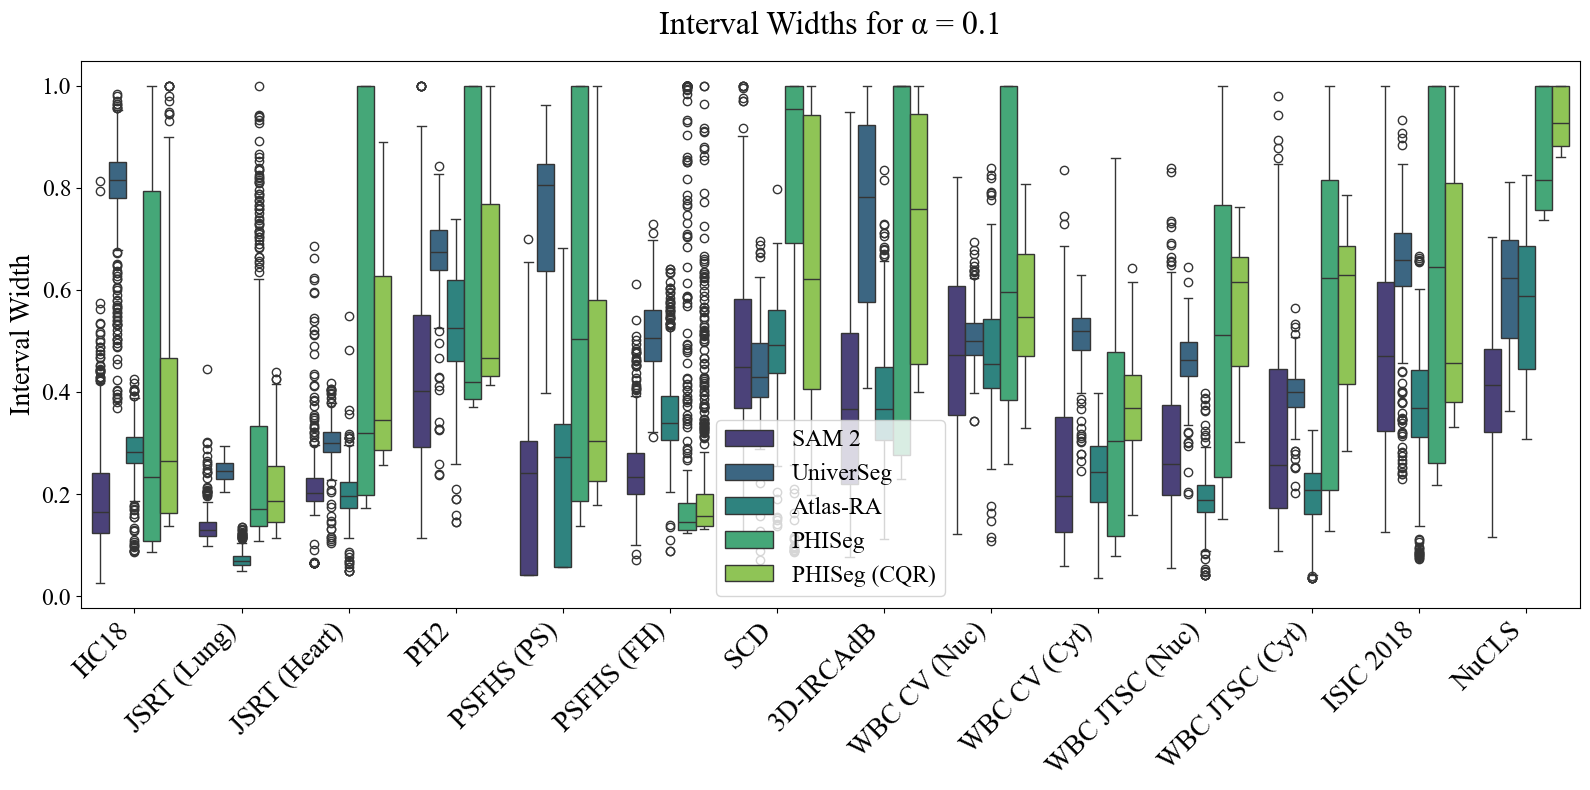

In [ ]:
alpha = 0.1
fig = plot_datasets_interval_widths(
    data=data,
    cal_method=quantile_calibrate,
    phiseg_data=phiseg_data,
    figsize=(16, 8),
    title=f'Interval Widths for α = {alpha}',
    p_l=0.4, p_h=0.95, alpha=alpha, n=32
)

plt.savefig('figures/interval_widths.svg', bbox_inches='tight')

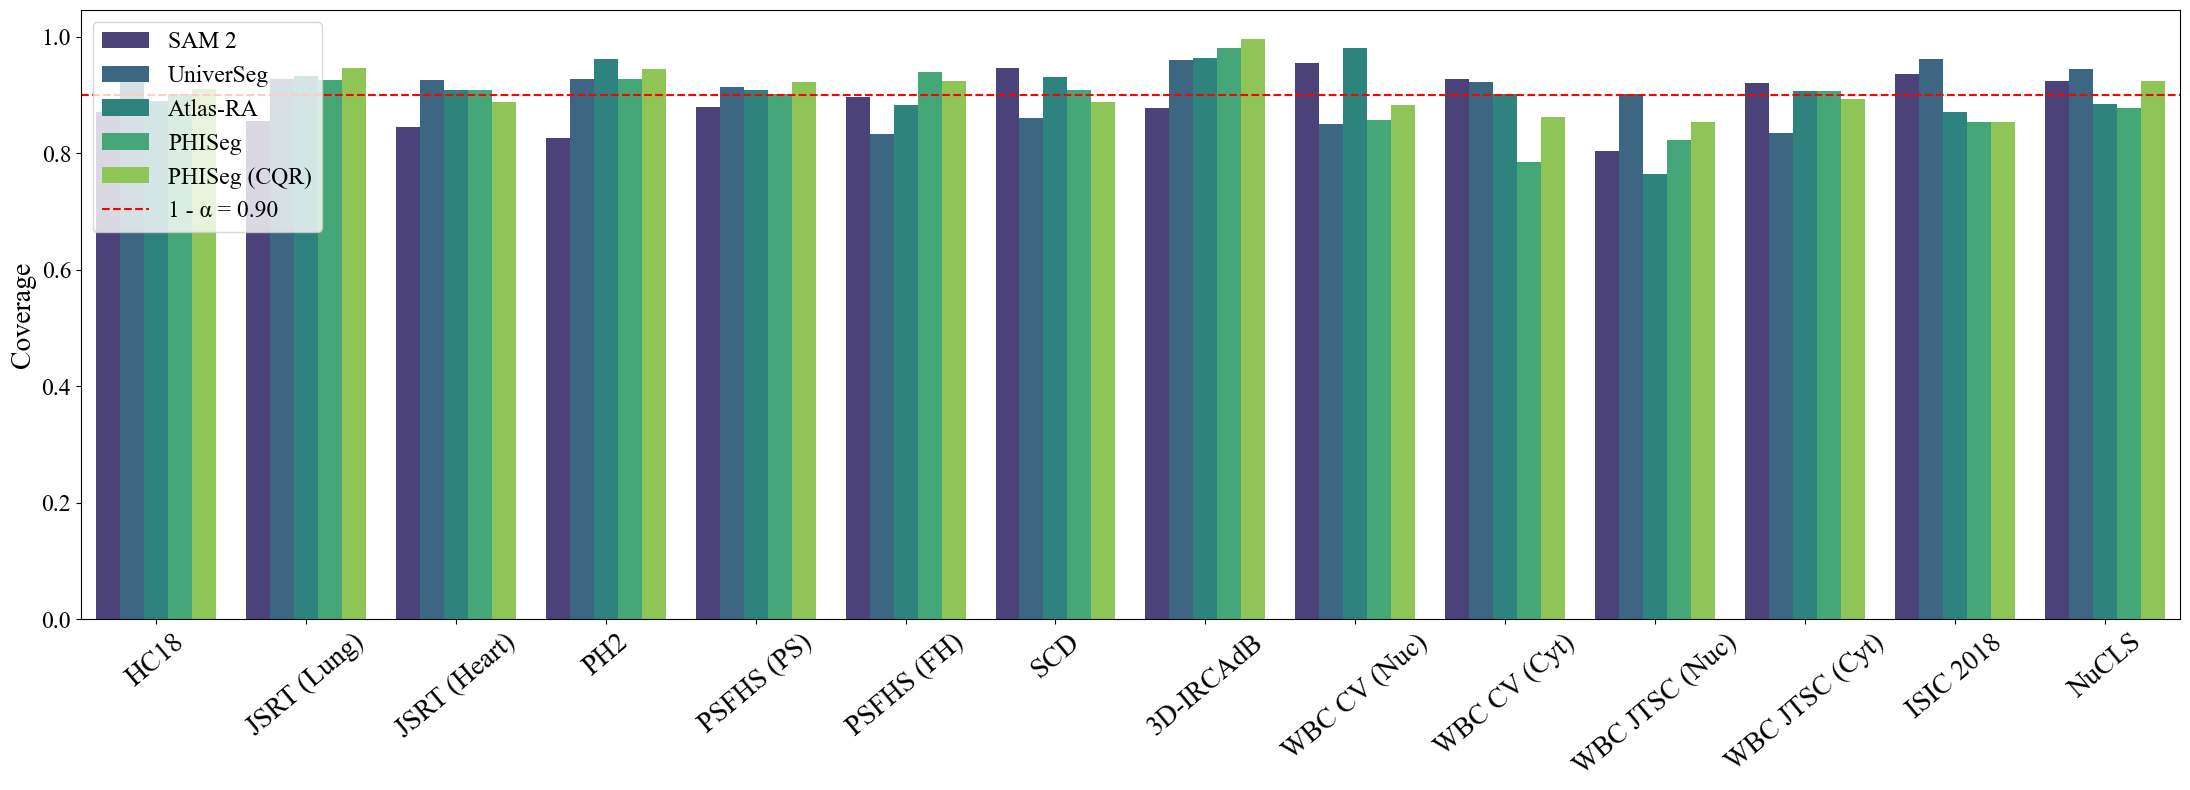

In [ ]:
alpha = 0.1
fig = plot_datasets_coverage(
    figsize=(22,8),
    data=data,
    cal_method=quantile_calibrate,
    alpha=alpha,
    phiseg_data=phiseg_data,
    title='Marginal coverage for different methods',
    p_l=0.4, p_h=0.95, n=32
)

plt.savefig('figures/coverage.svg', bbox_inches='tight')

#### Controlled test

In [ ]:
from scipy.stats import ks_2samp

    
def plot_nonconformity_histograms(result, title='Nonconformity Score Distributions'):
    # Extract calibration and test scores
    cal_scores  = np.array(result['scores'])
    test_scores = np.array(result['test_scores'])

    # Compute quantile threshold and fractions ≤ q̂
    qhat      = result['q']
    cal_frac  = np.mean(cal_scores  <= qhat)
    test_frac = np.mean(test_scores <= qhat)

    # Kolmogorov–Smirnov test (already computed in your traceback, so I'll just include it)
    stat, p_value = ks_2samp(cal_scores, test_scores)
    print(f"KS test p-value = {p_value:.4f}")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(cal_scores,  color='blue',   label='Calibration',
                 kde=True, stat='density', alpha=0.6, ax=ax)
    sns.histplot(test_scores, color='orange', label='Test',
                 kde=True, stat='density', alpha=0.6, ax=ax)

    # Use the LaTeX syntax for q-hat
    ax.axvline(qhat, color='blue', linestyle='--', label=r'$\hat{q}$ (90\%)')

    # Annotate with fractions and p‑value
    # Use LaTeX for all math symbols in textstr
    textstr = (f"Calibration $\\le \\hat{{q}}$: {cal_frac:.2f}\n"
               f"Test $\\le \\hat{{q}}$: {test_frac:.2f}"
              )
    ax.text(0.02, 0.97, textstr, transform=ax.transAxes,
            fontsize=12, verticalalignment='top', horizontalalignment='left',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Nonconformity Score', fontsize=13)
    ax.set_ylabel('Density', fontsize=13)
    ax.legend()
    ax.grid(True)
    fig.tight_layout()

    return fig

KS test p-value = 0.5363
KS test p-value = 0.5363


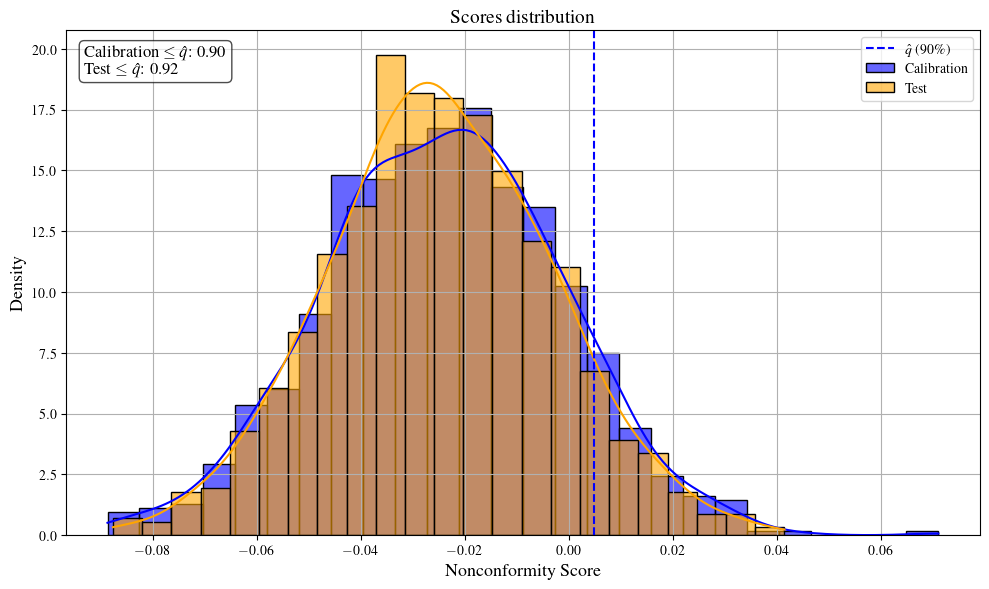

In [ ]:
# Generate RCA scores by adding Gaussian noise to real scores. Outputs are clipped to [0, 1]
def generate_rca_scores(real_scores, n_rca=50, noise_std=0.05):
    noise = np.random.normal(0, noise_std, size=(len(real_scores), n_rca))
    return np.clip(real_scores[:, None] + noise, 0, 1)


def generate_synthetic_dataset(n_cal=1000, n_test=1000, n_rca=32, noise_std=0.05):
    # Generate scores from a Beta distribution (bounded in [0, 1])
    real_cal = np.random.beta(2, 2, size=n_cal)
    real_test = np.random.beta(2, 2, size=n_test)

    rca_cal = generate_rca_scores(real_cal, n_rca=n_rca, noise_std=noise_std)
    rca_test = generate_rca_scores(real_test, n_rca=n_rca, noise_std=noise_std)

    return {
        'cal': {
            'Real score': real_cal,
            'RCA score': rca_cal,
        },
        'test': {
            'Real score': real_test,
            'RCA score': rca_test,
        }
    }

np.random.seed(1)
synthetic_data = generate_synthetic_dataset(n_cal=1000, n_test=1000, n_rca=32, noise_std=0.1)

alpha = 0.1
result = quantile_calibrate(synthetic_data, p_l=0.4, p_h=0.95, alpha=alpha)[0]

cal_scores = np.array(result['scores'])
test_scores = np.array(result['test_scores'])

stat, p_value = ks_2samp(cal_scores, test_scores)
print(f"KS test p-value = {p_value:.4f}")
fig = plot_nonconformity_histograms(result, title='Scores distribution')
plt.savefig('figures/scores_no_shift.svg', bbox_inches='tight', dpi=300)